In [237]:
import numpy as np
from scipy.optimize import linprog
from scipy.optimize import minimize
import quadprog


def quadratic_solver(n, M, regularizer):
    qp_G = np.matmul(M, M.T)
    qp_G += regularizer * np.eye(n)

    qp_a = np.zeros(n, dtype = np.float64)

    qp_C = np.zeros((n,n+1), dtype = np.float64)
    for i in range(n):
        qp_C[i,0] = 1.0
        qp_C[i,i+1] = 1.0
    qp_b = np.zeros(n+1, dtype = np.float64)
    qp_b[0] = 1.0
    meq = 1
    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    w = res[0]
    return w

class Density_Ratio_discounted(object):
    def __init__(self, num_state, gamma):
        self.num_state = num_state
        self.Ghat = np.zeros([num_state, num_state], dtype = np.float64)
        self.Nstate = np.zeros([num_state, 1], dtype = np.float64)
        self.initial_b = np.zeros([num_state], dtype = np.float64)
        self.gamma = gamma

    def reset(self):
        num_state = self.num_state
        self.Ghat = np.zeros([num_state, num_state], dtype = np.float64)
        self.Nstate = np.zeros([num_state, 1], dtype = np.float64)

    def feed_data(self, cur, next, initial, policy_ratio, discounted_t):
        if cur == -1:
            self.Ghat[next, next] -= discounted_t
        else:
            self.Ghat[cur, next] += policy_ratio * discounted_t
            self.Ghat[cur, initial] += (1-self.gamma)/self.gamma * discounted_t
            self.Ghat[next, next] -= discounted_t
            self.Nstate[cur] += discounted_t

    def density_ratio_estimate(self, regularizer = 0.001):
        Frequency = self.Nstate.reshape(-1)
        tvalid = np.where(Frequency >= 1e-20)
        G = np.zeros_like(self.Ghat)
        Frequency = Frequency/np.sum(Frequency)
        G[tvalid] = self.Ghat[tvalid]/(Frequency[:,None])[tvalid]		
        n = self.num_state
        x = quadratic_solver(n, G/50.0, regularizer)
        w = np.zeros(self.num_state)
        w[tvalid] = x[tvalid]/Frequency[tvalid]
        return x, w






In [291]:



import os
import sys
import argparse
import optparse
import subprocess
import numpy as np
#######from Density_Ratio_discrete import Density_Ratio_discrete, Density_Ratio_discounted
from Q_learning import Q_learning
from environment import random_walk_2d, taxi
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# import seaborn as sns
# sns.set(style="white")


def roll_out(state_num, env, policy, num_trajectory, truncate_size):
	SASR = []
	total_reward = 0.0
	frequency = np.zeros(state_num)
	for i_trajectory in range(num_trajectory):
		state = env.reset()
		sasr = []
		for i_t in range(truncate_size):
			#env.render()
			p_action = policy[state, :]
			action = np.random.choice(p_action.shape[0], 1, p = p_action)[0]
			next_state, reward = env.step(action)

			sasr.append((state, action, next_state, reward))
			frequency[state] += 1
			total_reward += reward
			#print env.state_decoding(state)
			#a = input()

			state = next_state
		SASR.append(sasr)
	return SASR, frequency, total_reward/(num_trajectory * truncate_size)

def train_density_ratio(SASR, policy0, policy1, den_discrete, gamma):
	for sasr in SASR:
		discounted_t = 1.0
		initial_state = sasr[0,0]
		for state, action, next_state, reward in sasr:
			discounted_t *= gamma
			policy_ratio = policy1[state, action]/policy0[state, action]
			den_discrete.feed_data(state, next_state, initial_state, policy_ratio, discounted_t)
		den_discrete.feed_data(-1, initial_state, initial_state, 1, 1-discounted_t)
		
	x, w = den_discrete.density_ratio_estimate()
	return x, w

def off_policy_evaluation_density_ratio(SASR, policy0, policy1, density_ratio, gamma):
	total_reward = 0.0
	self_normalizer = 0.0
	for sasr in SASR:
		discounted_t = 1.0
		for state, action, next_state, reward in sasr:
			policy_ratio = policy1[state, action]/policy0[state, action]
			total_reward += density_ratio[state] * policy_ratio * reward * discounted_t
			self_normalizer += density_ratio[state] * policy_ratio * discounted_t
			discounted_t *= gamma
	return total_reward / self_normalizer

def on_policy(SASR, gamma):
	total_reward = 0.0
	self_normalizer = 0.0
	for sasr in SASR:
		discounted_t = 1.0
		for state, action, next_state, reward in sasr:
			total_reward += reward * discounted_t
			self_normalizer += discounted_t
			discounted_t *= gamma
	return total_reward / self_normalizer

def importance_sampling_estimator(SASR, policy0, policy1, gamma):
	mean_est_reward = 0.0
	for sasr in SASR:
		log_trajectory_ratio = 0.0
		total_reward = 0.0
		discounted_t = 1.0
		self_normalizer = 0.0
		for state, action, next_state, reward in sasr:
			log_trajectory_ratio += np.log(policy1[state, action]) - np.log(policy0[state, action])
			total_reward += reward * discounted_t
			self_normalizer += discounted_t
			discounted_t *= gamma
		avr_reward = total_reward / self_normalizer
		mean_est_reward += avr_reward * np.exp(log_trajectory_ratio)
	mean_est_reward /= len(SASR)
	return mean_est_reward

def importance_sampling_estimator_stepwise(SASR, policy0, policy1, gamma):
	mean_est_reward = 0.0
	for sasr in SASR:
		step_log_pr = 0.0
		est_reward = 0.0
		discounted_t = 1.0
		self_normalizer = 0.0
		for state, action, next_state, reward in sasr:
			step_log_pr += np.log(policy1[state, action]) - np.log(policy0[state, action])
			est_reward += np.exp(step_log_pr)*reward*discounted_t
			self_normalizer += discounted_t
			discounted_t *= gamma
		est_reward /= self_normalizer
		mean_est_reward += est_reward
	mean_est_reward /= len(SASR)
	return mean_est_reward

def weighted_importance_sampling_estimator(SASR, policy0, policy1, gamma):
	total_rho = 0.0
	est_reward = 0.0
	for sasr in SASR:
		total_reward = 0.0
		log_trajectory_ratio = 0.0
		discounted_t = 1.0
		self_normalizer = 0.0
		for state, action, next_state, reward in sasr:
			log_trajectory_ratio += np.log(policy1[state, action]) - np.log(policy0[state, action])
			total_reward += reward * discounted_t
			self_normalizer += discounted_t
			discounted_t *= gamma
		avr_reward = total_reward / self_normalizer
		trajectory_ratio = np.exp(log_trajectory_ratio)
		total_rho += trajectory_ratio
		est_reward += trajectory_ratio * avr_reward

	avr_rho = total_rho / len(SASR)
	return est_reward / avr_rho/ len(SASR)

def weighted_importance_sampling_estimator_stepwise(SASR, policy0, policy1, gamma):
	Log_policy_ratio = []
	REW = []
	for sasr in SASR:
		log_policy_ratio = []
		rew = []
		discounted_t = 1.0
		self_normalizer = 0.0
		for state, action, next_state, reward in sasr:
			log_pr = np.log(policy1[state, action]) - np.log(policy0[state, action])
			if log_policy_ratio:
				log_policy_ratio.append(log_pr + log_policy_ratio[-1])
			else:
				log_policy_ratio.append(log_pr)
			rew.append(reward * discounted_t)
			self_normalizer += discounted_t
			discounted_t *= gamma
		Log_policy_ratio.append(log_policy_ratio)
		REW.append(rew)
	est_reward = 0.0
	rho = np.exp(Log_policy_ratio)
	#print 'rho shape = {}'.format(rho.shape)
	REW = np.array(REW)
	for i in range(REW.shape[0]):
		est_reward += np.sum(rho[i]/np.mean(rho, axis = 0) * REW[i])/self_normalizer
	return est_reward/REW.shape[0]


def Q_learning(env, num_trajectory, truncate_size, temperature = 2.0):
	agent = Q_learning(n_state, n_action, 0.01, 0.99)

	state = env.reset()
	for k in range(20):
		print 'Training for episode {}'.format(k)
		for i in range(50):
			for j in range(5000):
				action = agent.choose_action(state, temperature)
				next_state, reward = env.step(action)
				agent.update(state, action, next_state, reward)
				state = next_state
		pi = agent.get_pi(temperature)
		np.save('taxi-policy/pi{}.npy'.format(k), pi)
		SAS, f, avr_reward = roll_out(n_state, env, pi, num_trajectory, truncate_size)
		print 'Episode {} reward = {}'.format(k, avr_reward)
		heat_map(length, f, env, 'heatmap/pi{}.pdf'.format(k))

def heat_map(length, f, env, filename):
	p_matrix = np.zeros([length, length], dtype = np.float32)
	for state in range(env.n_state):
		x,y,_,_ = env.state_decoding(state)
		#x,y = env.state_decoding(state)
		p_matrix[x,y] = f[state]
	p_matrix = p_matrix / np.sum(p_matrix)
	
	sns.heatmap(p_matrix, cmap="YlGnBu")#, vmin = 0.0, vmax = 0.07)
	ppPDF = PdfPages(filename)
	ppPDF.savefig()
	ppPDF.close()
	plt.clf()

    
      
            
    
def model_based(n_state, n_action, SASR, pi, gamma):
    T = np.zeros([n_state, n_action, n_state], dtype = np.float32)
    R = np.zeros([n_state, n_action], dtype = np.float32)
    R_count = np.zeros([n_state, n_action], dtype = np.int32)
    for sasr in SASR:
        for state, action, next_state, reward in sasr:
            T[state, action, next_state] += 1
            R[state, action] += reward
            R_count[state, action] += 1
    d0 = np.zeros([n_state, 1], dtype = np.float32)

    for state in SASR[:,0,0].flat:
        d0[state, 0] += 1.0
    ###d0 = np.load("emp_hist.npy")
    t = np.where(R_count > 0)
    t0 = np.where(R_count == 0)
    R[t] = R[t]/R_count[t]
    R[t0] = np.mean(R[t])
    T = T + 1e-9	# smoothing
    T = T/np.sum(T, axis = -1)[:,:,None]
    Tpi = np.zeros([n_state, n_state])
    for state in range(n_state):
        for next_state in range(n_state):
            for action in range(n_action):
                Tpi[state, next_state] += T[state, action, next_state] * pi[state, action]
    dt = d0/np.sum(d0)
    dt = emp_hist
    dpi = np.zeros([n_state, 1], dtype = np.float32)
    truncate_size = SASR.shape[1]
    discounted_t = 1.0
    self_normalizer = 0.0
    for i in range(500):
        dpi += dt * discounted_t
        if i < 200:
            dt = np.dot(Tpi.T,dt)
        self_normalizer += discounted_t
        discounted_t *= gamma
    dpi /= self_normalizer
    Rpi = np.sum(R * pi, axis = -1)#####print Rpi
    return np.sum(dpi.reshape(-1) * Rpi)

def run_experiment(n_state, n_action, SASR, pi0, pi1, gamma):
	est_DENR = 0.0 ####off_policy_evaluation_density_ratio(SASR, pi0, pi1, w, gamma)
	est_naive_average = on_policy(SASR, gamma)
	est_IST = 0.0 ####importance_sampling_estimator(SASR, pi0, pi1, gamma)
	est_ISS = 0.0 ###importance_sampling_estimator_stepwise(SASR, pi0, pi1, gamma)
	est_WIST = 0.0 ###weighted_importance_sampling_estimator(SASR, pi0, pi1, gamma)
	est_WISS = 0.0 ###weighted_importance_sampling_estimator_stepwise(SASR, pi0, pi1, gamma)
	
	est_model_based = model_based(n_state, n_action, SASR, pi1, gamma)
	#return est_model_based
	return est_DENR, est_naive_average, est_IST, est_ISS, est_WIST, est_WISS, est_model_based



In [296]:
estimator_name = ['On Policy', 'Density Ratio', 'Naive Average', 'IST', 'ISS', 'WIST', 'WISS', 'Model Based']
length = 5
env = taxi(length)
n_state = env.n_state
n_action = env.n_action



behavior_ID = 4
target_ID = 5

pi_target = np.load('taxi-policy/pi19.npy')
alpha = 0.2  # mixture ratio
nt = 50 # num_trajectory
ts = 2000 # truncate_size
gm = 0.98 # gamma
pi_behavior = np.load('taxi-policy/pi18.npy')

pi_behavior = alpha * pi_target + (1-alpha) * pi_behavior

res = np.zeros((8, 20), dtype = np.float32)
for k in range(20):
    np.random.seed(k)
    SASR0, _, _ = roll_out(n_state, env, pi_behavior, nt, ts)
    res[1:,k] = run_experiment(n_state, n_action, np.array(SASR0), pi_behavior, pi_target, gm)

    np.random.seed(4)
    SASR, _, _ = roll_out(n_state, env, pi_target, nt, ts)
    res[0, k] = on_policy(np.array(SASR), gm)

    print('------seed = {}------'.format(k))
    for i in range(8):
        print('  ESTIMATOR: '+estimator_name[i]+ ', rewards = {}'.format(res[i,k]))
    print('----------------------')



-0.01919798694424448
-0.03784591003033142
-0.055859425900672756
-0.07326919255700587
-0.09005588869961252
-0.10426009160770482
-0.11606854669571533
-0.12554538254879308
-0.13290512194447765
-0.13847050072121048
-0.14265671298345353
-0.1457392800978484
-0.14800158727779314
-0.1496958395448839
-0.15103304416063149
-0.15217727929495511
-0.15325099647268356
-0.15433085667964547
-0.1554590190813581
-0.15665152597012702
-0.15790651022910474
-0.15921096906685064
-0.16054661477522048
-0.1618936029473366
-0.16323335224144386
-0.16455031228202216
-0.1658328492945926
-0.16707340460947262
-0.16826817131728078
-0.16941643769187914
-0.1705198015832229
-0.1715813833198938
-0.17260512429300606
-0.17359521713719955
-0.17455568678501493
-0.1754901148883684
-0.17640149065896712
-0.17729216509431883
-0.17816388035026046
-0.17901784716569727
-0.179854850469564
-0.18067535962656842
-0.18147963438368686
-0.1822678146908823
-0.18303999180943203
-0.18379625994847199
-0.18453674814423374
-0.18526163572029378
-0

-0.22034371473234932
-0.2203443226060034
-0.22034491747789736
-0.2203455010511181
-0.220346072981482
-0.22034663307744684
-0.2203471825968991
-0.22034772037665706
-0.2203482479944761
-0.22034876507540177
-0.22034927160360673
-0.22034976782826857
-0.22035025433740638
-0.22035073094267768
-0.22035119817970863
-0.22035165600862391
-0.22035210484440282
-0.22035254437812601
-0.22035297544783006
-0.22035339773324808
-0.22035381200869458
-0.22035421745166678
-0.22035461538351817
-0.22035500501568497
-0.22035538667469096
-0.22035576088094833
-0.22035612769578783
-0.22035648713300188
-0.22035683912074636
-0.22035718370610755
-0.22035752216812737
-0.22035785352193207
-0.22035817806608413
-0.22035849630329948
-0.22035880815092793
-0.22035911366731584
-0.22035941339904075
-0.22035970678082747
-0.2203599941742428
-0.2203602767415206
-0.22036055328342724
-0.2203608238840392
-0.22036108940128346
-0.22036134967375473
-0.22036160446035571
-0.22036185397237135
-0.22036209931635808
-0.2203623391831398
-0

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.22037405540601063
-0.2203740554

KeyboardInterrupt: 

In [ ]:
def model_based(n_state, n_action, SASR, pi, gamma):
    Q_table = np.zeros([n_state, n_action], dtype = np.float32)
    T = np.zeros([n_state, n_action, n_state], dtype = np.float32)
    R = np.zeros([n_state, n_action], dtype = np.float32)
    R_count = np.zeros([n_state, n_action], dtype = np.int32)
    for sasr in SASR:
        for state, action, next_state, reward in sasr:
            state = np.int(state)
            action = np.int(action)
            next_state = np.int(next_state)
            T[state, action, next_state] += 1
            R[state, action] += reward
            R_count[state, action] += 1
    d0 = np.ones([n_state, 1], dtype = np.float32)

    t = np.where(R_count > 0)
    t0 = np.where(R_count == 0)
    R[t] = R[t]/R_count[t]
    ###R[t0] = np.mean(R[t])
    T = T + 1e-9	# smoothing
    T = T/np.sum(T, axis = -1)[:,:,None]
    
    ddd = np.load("emp_hist.npy").reshape(-1)
    ####ddd = d0/np.sum(d0)
    for i in range(5000):
        Q_table_new = np.zeros([n_state, n_action], dtype = np.float32)
        V_table = np.sum(Q_table*pi,1)
        for state in range(n_state):
            for action in range(n_action):
                Q_table_new[state,action] = R[state,action]+gamma*np.sum(T[state, action, :]*V_table)
        Q_table = np.copy(Q_table_new)
        
        print np.sum(np.sum(Q_table*pi,1).reshape(-1)*ddd)*(1-gamma)
    return np.sum(np.sum(Q_table*pi,1).reshape(-1)*ddd)*(1-gamma), Q_table

print n_state
print n_action
q_table, R = model_based(n_state,n_action,SASR0,pi_target,gamma)

In [285]:
###print q_table
print q_table
print np.sum(q_table*pi,1)
ddd = np.load("emp_hist.npy")
print ddd
d0 = np.ones([n_state, 1], dtype = np.float32)
d0 = d0/np.sum(d0)
print np.mean(np.sum(q_table*pi,1))
print (np.sum(q_table*pi,1)

[[-1.        -1.        -0.8696808 -1.        -0.8696808 -0.8696808]
 [-1.        -1.        -1.        -1.        -1.        -1.       ]
 [-1.        -1.        -1.        -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        -1.        -1.        -1.       ]
 [-0.8696808 -0.8696808 -0.8696808 -0.8696808 -0.8696808 20.       ]
 [-1.        -1.        -1.        -1.        -1.        -1.       ]]
[-0.93808783 -1.         -1.         ... -1.         19.97284916
 -1.        ]
[[0.       ]
 [0.       ]
 [0.       ]
 ...
 [0.       ]
 [0.       ]
 [0.0024948]]
-0.5028072285212929
(2000, 2000)


In [172]:
def model_based(n_state, n_action, SASR, pi, gamma):
    Ghat = 0.0*np.identity(n_state*n_action, dtype = np.float64)
    Nstate = np.zeros([n_state*n_action, 1], dtype = np.float64)
    print gamma
    for sasr in SASR:
        for state, action, next_state, reward in sasr:
            state = np.int(state)
            action = np.int(action)
            next_state = np.int(next_state)
            ccc = 0.0 
            v_t = pi[next_state,:]
            Ghat[state*n_action+action,state*n_action+action] +=1.0
            Ghat[state*n_action+action,next_state*n_action:(next_state+1)*n_action] -= gamma*v_t 
            Nstate[state*n_action+action]+= reward
            
    return Ghat,Nstate

In [208]:
def quadratic_solver(n, M, bbb ,tvalid, regularizer):
    qp_G = np.matmul(M.T, M)
    qp_G += regularizer * np.eye(n)

    qp_a = np.matmul(M.T, bbb)###np.zeros(n, dtype = np.float64)

    qp_C = np.zeros((n,n), dtype = np.float64)
    for i in range(n):
        if i in tvalid:
            qp_C[i,i] = 1.0
    qp_b = np.zeros(n, dtype = np.float64)
   
    meq = n_state*n_action
    res = quadprog.solve_qp(qp_G, qp_a.reshape(-1), qp_C, qp_b, meq)
    w = res[0]
    return w


Ghat, Nsate = model_based(n_state,n_action,SASR,pi_target,gamma)
print Ghat.shape

for sasr in SASR:
        for state, action, next_state, reward in sasr:
            count[state*n_action+action] += 1
hist = count/np.sum(count) 
tvalid = np.where(hist<0.00002)[0]
print tvalid.shape

0.9
(12000, 12000)
(6831,)


In [ ]:
q_new = quadratic_solver(n_state*n_action, Ghat, Nsate, tvalid,0.0001 ).reshape([n_state,n_action])
qqq = np.sum(q_new*pi_target)*(1.0-gamma)/n_state
print qqq

In [210]:
qqq = np.sum(q_new*pi_target)*(1.0-gamma)/n_state
print qqq

0.03018063183469902


In [202]:
count = np.zeros([n_state*n_action, 1], dtype = np.float64)
    
for sasr in SASR:
        for state, action, next_state, reward in sasr:
            count[state*n_action+action] += 1
            
hist = count/np.sum(count)
print hist[hist<0.0001]
print np.sum(hist<0.00002)

[1.e-05 0.e+00 1.e-05 ... 0.e+00 0.e+00 0.e+00]
6831


In [161]:
pi = pi_target
SASR = np.array(SASR0)[0:1,:,:]

print SASR.shape
gamma = gm
def model_based(n_state, n_action, SASR, pi, gamma):
    Ghat = 100.0*np.identity(n_state*n_action, dtype = np.float64)
    print Ghat[0,0]
    Nstate = np.zeros([n_state*n_action, 1], dtype = np.float64)
    for sasr in SASR:
        for state, action, next_state, reward in sasr:
            state = np.int(state)
            action = np.int(action)
            next_state = np.int(next_state)
            ccc = 0.0 
            v_t = pi[next_state,:].reshape(1,n_action)
           
            ccc = 1.0-gamma*np.matmul(v_t, Ghat[next_state*n_action:(next_state+1)*n_action,state*n_action+action])+Ghat[state*n_action+action,state*n_action+action]
            Ghat-= np.matmul(Ghat[:,state*n_action+action:state*n_action+action+1],Ghat[state*n_action+action:state*n_action+action+1,:]  )/ccc- gamma*np.matmul(Ghat[:,state*n_action+action:state*n_action+action+1],np.matmul(v_t,Ghat[next_state*n_action:(next_state+1)*n_action,:]) )/ccc
            Nstate[state*n_action+action]+= reward
            
            q_new = np.matmul(Ghat,Nsate).reshape([n_state,n_action])
            qqq = np.sum(q_new*pi)
            print (1.0-gamma)*qqq/n_state
            
    return Ghat,Nstate

print 


(1, 500, 4)



In [162]:
Ghat, Nsate = model_based(n_state,n_action,SASR,pi,gamma)

100.0
0.04978918695088298
0.04988746721090804
0.051746915461115144
0.05156158927916309
0.051302526018339054
0.05844379737906491
0.05889025970804556
0.06401020266484575
0.0644619891839912
0.0653584619554931
0.06665086068646527
0.37914853736953874
-0.013776470209741775
-0.012854047592156696
-0.012255391030254255
-0.012232175988823372
-0.012884961494010756
-0.01175486537851949
-0.011246957162736377
-0.010458396826746165
-0.0073784509673194025
-0.005838910300163585
-0.005774446478463891
-0.0017011023642578703
-0.00019936367256613889
0.00022966245215614935
0.0013306446361296793
0.0011851197371374382
0.003068575010967611
0.0030048083529251052
0.0030048083529251052
0.0030048083529251052
0.0030048083529251052
0.0030048083529251052
0.0030048083529251052
0.0030048083529251052
0.0030048083529251052
0.0030048083529251052
0.0029846452372513364
0.002972175302618139
0.002950012924319981
0.0029794759285088593
0.002952426917250363
0.002952426917250363
0.002952426917250363
0.002952426917250363
0.0029524

KeyboardInterrupt: 

In [148]:
q_new = np.matmul(Ghat,Nsate).reshape([5,2])
qqq = np.sum(q_new*pi)
print (1.0-gamma)*qqq/n_state


[[ 9.97090132e-05 -2.90986845e-07 -2.90986845e-07 -2.90986845e-07
  -2.90986845e-07]
 [-2.90986845e-07  9.97090132e-05 -2.90986845e-07 -2.90986845e-07
  -2.90986845e-07]
 [-2.90986845e-07 -2.90986845e-07  9.97090132e-05 -2.90986845e-07
  -2.90986845e-07]
 [-2.90986845e-07 -2.90986845e-07 -2.90986845e-07  9.97090132e-05
  -2.90986845e-07]
 [-2.90986845e-07 -2.90986845e-07 -2.90986845e-07 -2.90986845e-07
   9.97090132e-05]]
20.0


In [30]:
pi = pi_target
SASR = np.array(SASR0)
gamma = gm
T = np.zeros([n_state, n_action, n_state], dtype = np.float32)
R = np.zeros([n_state, n_action], dtype = np.float32)
R_count = np.zeros([n_state, n_action], dtype = np.int32)
for sasr in SASR:
    for state, action, next_state, reward in sasr:
        T[state, action, next_state] += 1
        R[state, action] += reward
        R_count[state, action] += 1
d0 = np.zeros([n_state, 1], dtype = np.float32)


In [43]:
for state in SASR[:,0,0].flat:

    d0[state, 0] += 1.0

In [36]:
t = np.where(R_count > 0)
t0 = np.where(R_count == 0)
R[t] = R[t]/R_count[t]
R[t0] = np.mean(R[t])
T = T + 1e-9	# smoothing
T = T/np.sum(T, axis = -1)[:,:,None]
Tpi = np.zeros([n_state, n_state])
for state in range(n_state):
    for next_state in range(n_state):
        for action in range(n_action):
            Tpi[state, next_state] += T[state, action, next_state] * pi[state, action]
            

In [47]:
dt = d0/np.sum(d0)
dpi = np.zeros([n_state, 1], dtype = np.float32)
truncate_size = SASR.shape[1]
discounted_t = 1.0
self_normalizer = 0.0

print truncate_size


for i in range(truncate_size):
    dpi += dt * discounted_t
    if i < 50:
        dt = np.dot(Tpi.T,dt)
    self_normalizer += discounted_t
    discounted_t *= gamma
print self_normalizer
dpi /= self_normalizer
Rpi = np.sum(R * pi, axis = -1)
print dpi.shape

print  np.sum(dpi.reshape(-1) * Rpi)

500
99.3429516958
(2000, 1)
-0.08709696644729789


In [171]:
print Rpi.shape
print dpi

print pi.shape

(2000,)
[[-1.        -0.8605105 -0.8605105 -0.8605105 -0.8605105 -0.8605105]
 [-1.        -1.        -1.        -1.        -1.        -0.8605105]
 [-1.        -1.        -1.        -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        -1.        -1.        -1.       ]
 [-0.8605105 -0.8605105 -0.8605105 -0.8605105 -0.8605105 20.       ]
 [-1.        -1.        -1.        -1.        -1.        -1.       ]]
(2000, 6)


In [132]:
quadratic_solver(3,aaa.T,-ccc,0.00)

(array([-1., -2., -7.]), -3492.2450000000003, array([-1., -2., -7.]), array([1, 0], dtype=int32), array([0., 0., 0., 0.]), array([], dtype=int32))


array([-1., -2., -7.])

In [130]:
def quadratic_solver(n, M, bbb , regularizer):
    qp_G = np.matmul(M, M.T)
    qp_G += regularizer * np.eye(n)

    qp_a = np.matmul(M, bbb)###np.zeros(n, dtype = np.float64)
    
    qp_C = np.zeros((n,n+1), dtype = np.float64)
    for i in range(n):
        qp_C[i,0] = 0.0
        qp_C[i,i+1] = 0.0
    qp_b = np.zeros(n+1, dtype = np.float64)
    qp_b[0] = 0.0
    meq = 0.0

    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    print res
    w = res[0]
    return w

In [7]:
weight = np.load("weight.npy")

(array([1.971e+03, 1.000e+01, 1.100e+01, 5.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-6.17277964e-15,  3.80119639e-06,  7.60239278e-06,  1.14035892e-05,
         1.52047856e-05,  1.90059820e-05,  2.28071783e-05,  2.66083747e-05,
         3.04095711e-05,  3.42107675e-05,  3.80119639e-05]),
 <a list of 10 Patch objects>)

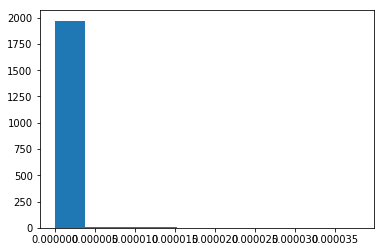

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(weight)

In [9]:
GGG =np.load("GGG.npy")
auxi = np.load("aixo.npy")

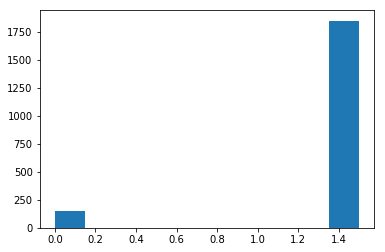

In [11]:
plt.hist(auxi)
plt.show()

(array([1.000000e+00, 1.000000e+00, 0.000000e+00, 4.000000e+00,
        9.000000e+00, 9.000000e+00, 7.900000e+01, 3.999689e+06,
        1.920000e+02, 1.600000e+01]),
 array([-1646.07980349, -1434.08032224, -1222.08084099, -1010.08135975,
         -798.0818785 ,  -586.08239725,  -374.082916  ,  -162.08343475,
           49.9160465 ,   261.91552775,   473.915009  ]),
 <a list of 10 Patch objects>)

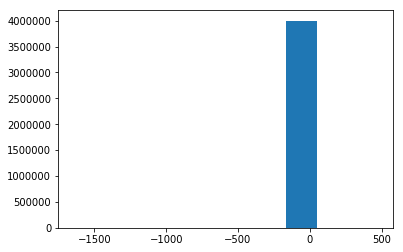

In [12]:
plt.hist(GGG.reshape(-1))

In [17]:
print np.array(SASR0).shape

(50, 2000, 4)


In [88]:
ttt, ttt1, ttt2 = roll_out(n_state, env, pi_behavior, 1000*10000, 1)

In [89]:
hist = np.array(ttt)[:,0,0]

In [68]:
print hist

[1094   19  939 ... 1754  754 1284]


In [90]:
histhist = np.zeros([n_state])
for i in hist:
    histhist[i] += 1
    
emp_hist = histhist/np.sum(histhist)    

In [91]:

emp_hist = emp_hist.reshape([n_state,1])

In [92]:
####np.save("emp_hist",emp_hist)

In [93]:
###emp_hist = np.load("emp_hist.npy")